In [1]:
import os
import numpy as np
import cv2
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
import joblib
import json
import random
from skimage.feature import hog
from skimage import exposure

**PATHS**

In [2]:
image_path      = '../../../dataset/images'
training_path   = os.path.join(image_path, 'training')
original_path   = os.path.join(training_path, 'original')
processed_path  = os.path.join(training_path, 'processed')

**LISTAS DE IMAGENES**

In [3]:
original  = [os.path.join(original_path, image) for image in os.listdir(original_path)]
processed  = [os.path.join(processed_path, image) for image in os.listdir(processed_path)]

**RANGOS DE COLOR**

- Los siguientes rangos de colores son lo mejorcito

In [4]:
lower_red_2 = np.array([170, 60, 60])
upper_red_2 = np.array([179, 255, 255])

lower_red_1 = np.array([0, 60, 60])
upper_red_1 = np.array([8, 255, 255])

lower_orange = np.array([8, 120, 80])
upper_orange = np.array([21, 255, 255])

lower_yellow = np.array([21, 50, 80])
upper_yellow = np.array([25, 255, 255])

lower_green = np.array([25, 40, 40])
upper_green = np.array([100, 255, 255])

In [5]:
labels  = []

for image_file, mask_file in zip(original, processed):
    # Leer la imagen y la máscara
    image = cv2.imread(image_file)
    mask  = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Convertir la imagen de BGR a HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Aplicar la máscara
    fruit = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    # Contar el número de píxeles en cada rango
    conteo = {
        'V' : np.sum(np.all(np.logical_and(lower_green  <= fruit, fruit <= upper_green), axis=-1)),
        'R1': np.sum(np.all(np.logical_and(lower_red_1  <= fruit, fruit <= upper_red_1), axis=-1)),
        'R2': np.sum(np.all(np.logical_and(lower_red_2  <= fruit, fruit <= upper_red_2), axis=-1)),
        'A' : np.sum(np.all(np.logical_and(lower_yellow <= fruit, fruit <= upper_yellow), axis=-1)),
        'N' : np.sum(np.all(np.logical_and(lower_orange <= fruit, fruit <= upper_orange), axis=-1))
    }
    conteo_por_rango = {
        'V': conteo['V'],
        'R': conteo['R1'] + conteo['R2'],
        'A': conteo['A'],
        'N': conteo['N']
    }

    sorted_conteo = sorted(conteo_por_rango.items(), key=lambda x: x[1], reverse=True)

    # Obtener el segundo elemento más grande
    segundo_mas_grande = sorted_conteo[1]

    # Obtener la etiqueta y el valor del segundo elemento más grande
    etiqueta_segundo_mas_grande = segundo_mas_grande[0]
    valor_segundo_mas_grande    = segundo_mas_grande[1]

    # Obtener la etiqueta basándose en el rango con el mayor conteo
    etiqueta = max(conteo_por_rango, key = conteo_por_rango.get)
    if (etiqueta_segundo_mas_grande == 'R')and(valor_segundo_mas_grande > 0.35*conteo_por_rango[etiqueta]):
        etiqueta = 'R'
        
    labels.append(etiqueta)

**Pasamos la lista de labels a una lìsta de coordenadas para las frutas**

In [6]:
conversions = {'V' :-20, 'R' : -10, 'A' : 10, 'N' : 20}
coordinates = []
for label in labels:
    coordinates.append(conversions[label])

**Pasamos las coordenadas a un diccionario primero para combinarlo con las circularidades**

In [7]:
names   = [os.path.basename(file) for file in original]
colores = dict.fromkeys(names)
for coordinate, key in zip(coordinates, colores.keys()):
    colores[key] = coordinate

**Ahora probamos con los momentos de Hu**

- En principio andan bien los momentos de Hu desde el 1 hasta el 3. Esos son los que usamos pero de todas maneras no permiten la separación del grupos de las naranjas de las manzanas anaranjadas así que las vamos a eliminar

In [18]:
hu = dict.fromkeys(names)

for name, mask_file in zip(hu.keys(), processed):
    image_file  = os.path.join(original_path, name)
    image       = cv2.imread(image_file)
    mask        = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

    # Recuperar la fruta utilizando la máscara
    fruit   = cv2.bitwise_and(image, image, mask = mask)

    # Encontrar el rectángulo delimitador de la fruta
    (x, y, w, h) = cv2.boundingRect(mask)

    # Recortar la imagen original para obtener solo la región de la fruta
    trimed  = fruit[y:y + h, x:x + w]

    # Convertir la imagen a escala de grises si es necesario
    trimed_gray = cv2.cvtColor(trimed, cv2.COLOR_BGR2GRAY)

    # Calcular los momentos de la imagen
    momentos = cv2.moments(trimed_gray)

    # Calcular los momentos de Hu
    momentos_hu = cv2.HuMoments(momentos)

    # Aplicar logaritmo a los momentos de Hu para mejorar la escala
    log_moments_hu = -np.sign(momentos_hu) * np.log10(np.abs(momentos_hu))
    log_moments_hu = log_moments_hu.reshape(-1)
    hu[name]       = log_moments_hu

**Unimos las medidas**

In [108]:
combinacion = dict.fromkeys(names)
for key, moment in hu.items():
    combinacion[key] = np.append(moment[1:4], colores[key])

In [109]:
# Obtener los valores de circularidad como un array de NumPy
features = np.vstack(list(combinacion.values()))

# Especificar el número de clusters (k)
num_clusters = 4

# Aplicar KMeans
kmeans = KMeans(n_clusters = num_clusters)
kmeans.fit(features)

# Obtener las etiquetas de cluster para cada imagen
labels = kmeans.labels_

c:\Users\Juan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [110]:
clusters = dict.fromkeys(set(labels))
for file, label in zip(combinacion.keys(), labels):
    if clusters[label] is None:
        clusters[label] = []
    clusters[label].append(file)

0


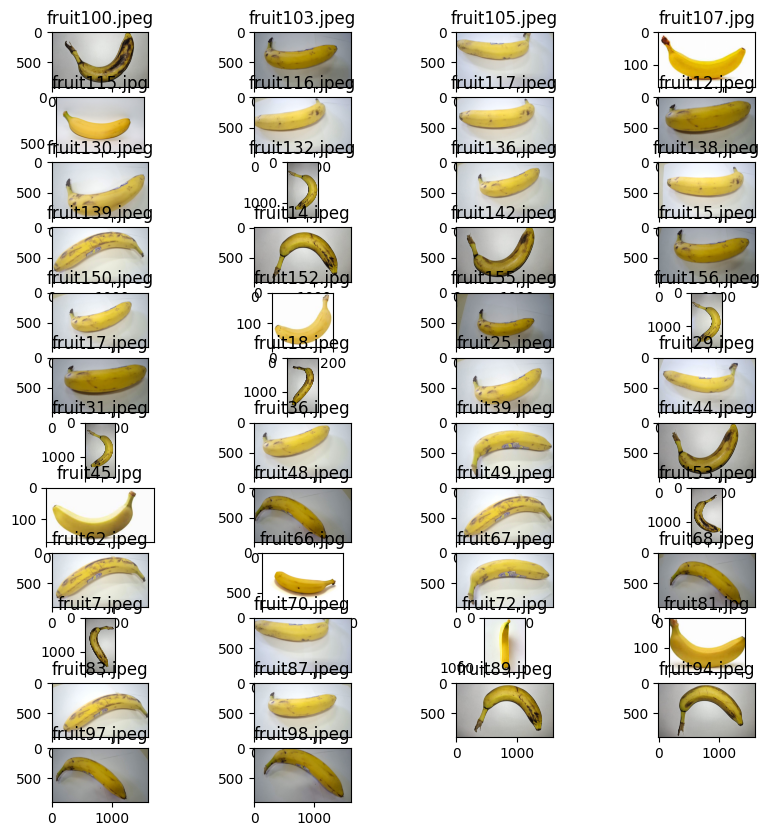

1


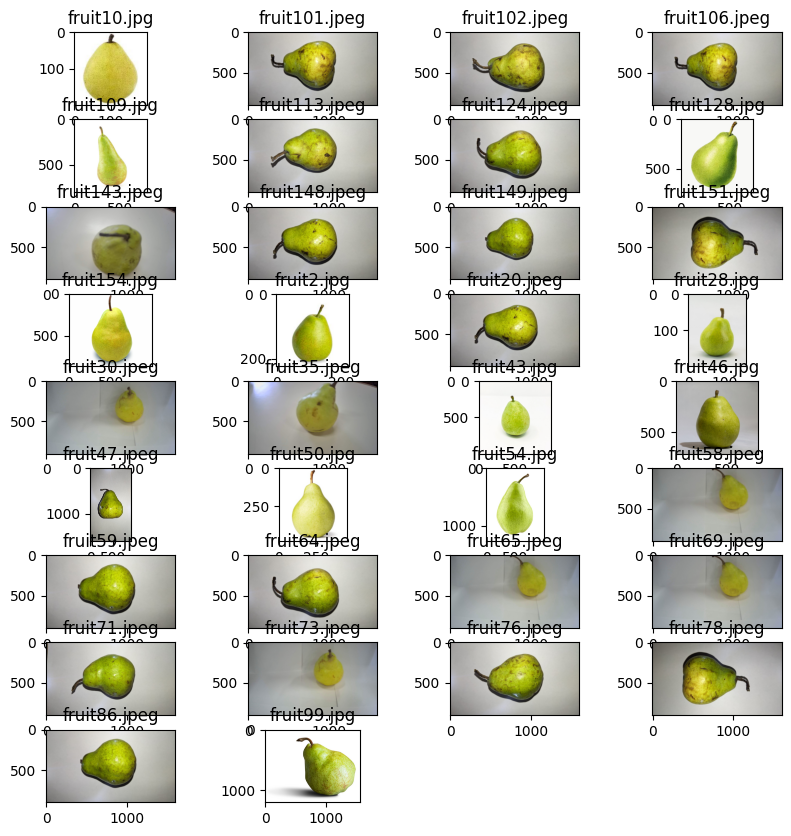

2


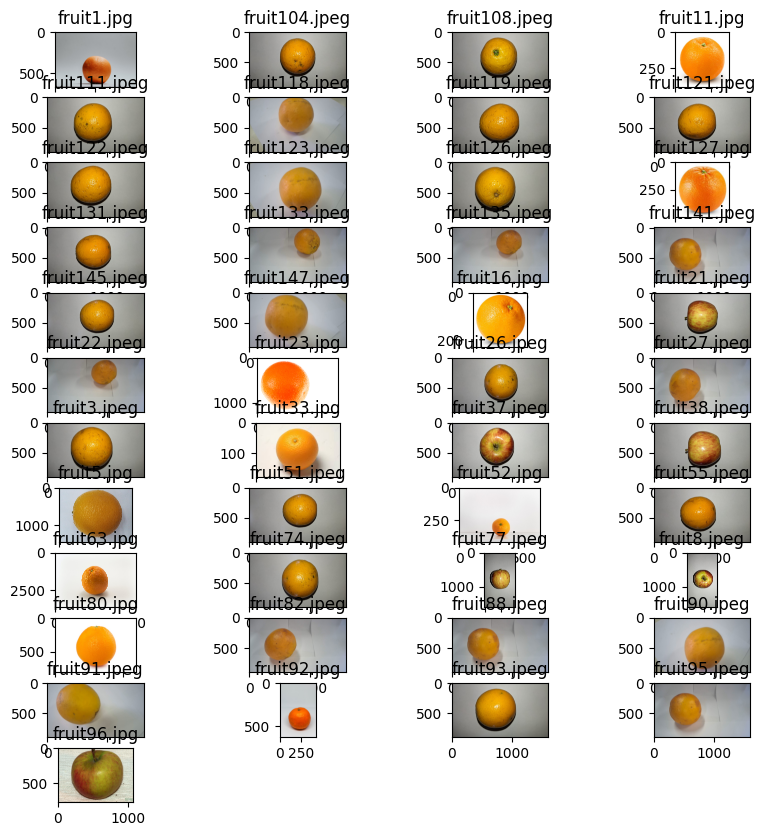

3


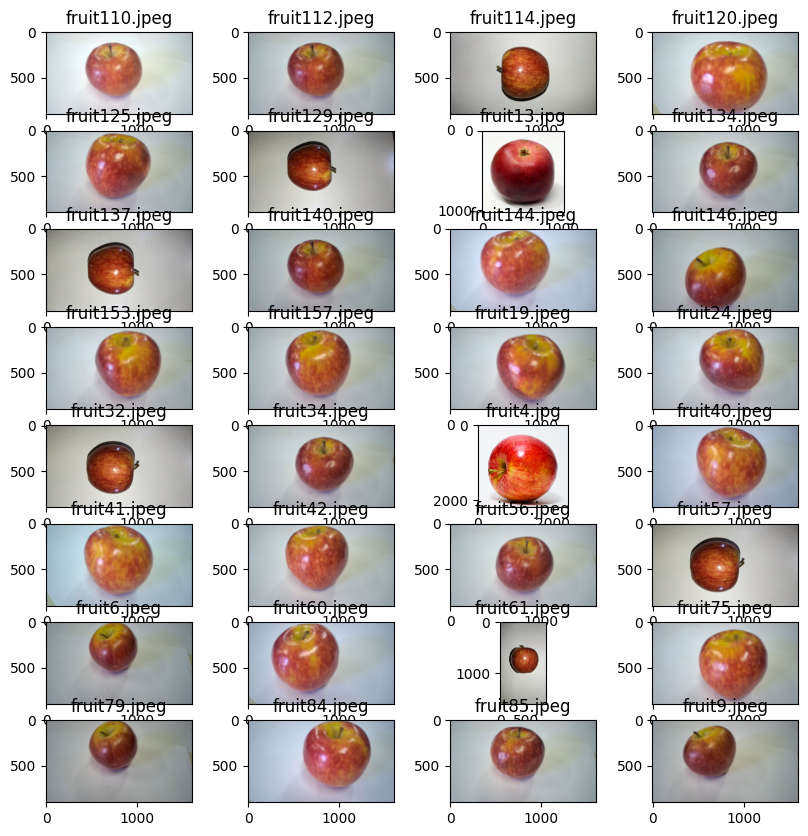

In [111]:
for key, cluster in clusters.items():
    print(key)
    cols = 4
    rows = len(cluster)//cols

    if len(cluster)%cols != 0:
        rows += 1

    plt.figure(figsize = (10, 10))
    for i, element in enumerate(cluster):
        element = os.path.join(original_path, element)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(cv2.imread(element), cv2.COLOR_BGR2RGB))
        plt.title(os.path.basename(element))
    plt.show()